In [9]:
import pickle
import utilities as ut
import sklearn.metrics as met
#from SAM import SAM
import utilities_full as ut2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from SAM_iter import SAM
import scipy as sp
from graph_tool.all import Graph, local_clustering
def generate_graph(graph):
    Npca = graph.copy()
    G = Graph(directed=True)

    Npca[np.arange(Npca.shape[0]), np.arange(Npca.shape[0])] = 0

    G.add_edge_list(np.transpose(Npca.nonzero()))
    return G

def SEURAT(adata):
    pca,_,_,_ = ut2.do_SEURAT4(adata.copy(),NN=3000)
    return pca
def local_clust(graph):
    G = generate_graph(graph)
    return np.mean(list(local_clustering(G, undirected=False)))


def l2disp(data, graph, k, N):
    davg = graph.dot(data / k)
    mu = davg.mean(0)

    disp = davg.var(0)[mu > 0] / mu[mu > 0]
    disp[np.isnan(disp)] = 0
    return np.sqrt(np.sum(np.sort(disp)[-N:]**2))

def modularity(graph, cl):
    indegree = graph.sum(0).flatten()
    outdegree = graph.sum(1).flatten()
    m = graph.sum()

    C = np.zeros(graph.shape)
    for i in range(cl.max() + 1):
        idxs = np.where(cl == i)[0]
        idxs1 = np.repeat(idxs, idxs.size)
        idxs2 = np.tile(idxs, idxs.size)
        C[idxs1, idxs2] = 1

    Q = ((graph - indegree[:, None] * outdegree[None, :] / m) * C / m).sum()
    return Q

In [22]:
sam=SAM()
sam.load_data('schisto2.5_tpm.csv')
sam.preprocess_data()

pca = SEURAT(sam.adata_raw.copy())

nnm = sp.sparse.csr_matrix(ut.dist_to_nn(ut.compute_distances(pca,'correlation'),20))

3000


In [ ]:
sam.run(nnm,max_iter=10,stopping_condition=0)

In [31]:
import copy
sam2 = copy.deepcopy(sam)

In [33]:
NS=[]
for i in range(10):
    print(i)
    numcells = 338
    k=20
    edm = sp.sparse.coo_matrix((numcells, numcells), dtype='i').tolil()
    nums = np.arange(edm.shape[1])
    RINDS = np.random.randint(
        0, numcells, (k - 1) * numcells).reshape((numcells,(k - 1)))
    RINDS = np.hstack((nums[:, None], RINDS))

    edm[np.tile(np.arange(RINDS.shape[0])[:, None],
                (1, RINDS.shape[1])).flatten(), RINDS.flatten()] = 1
    edm = edm.tocsr()

    sam2.run(edm,max_iter=10,stopping_condition=0,verbose=False)
    NS.append(sam2.Ns)

0
1
2
3
4
5
6
7
8
9


In [ ]:
cly = sam.louvain_clustering(X=nnm)
nacc_seur = local_clust(nnm.A)
mod_seur = modularity(nnm.A,cly)
disp_seur = l2disp(sam.adata.X.A,nnm.A,20,100)

In [40]:
nai = np.zeros((len(sam.Ns)))
moi = np.zeros((len(sam.Ns)))
dii = np.zeros((len(sam.Ns)))

for i,N in enumerate(sam.Ns):
    cly = sam.louvain_clustering(X=N)
    nai[i] = local_clust(N.A)
    moi[i] = modularity(N.A,cly)
    dii[i] = l2disp(sam.adata.X.A,N.A,20,100)

In [34]:
na = np.zeros((10,len(sam.Ns)))
mo = np.zeros((10,len(sam.Ns)))
di = np.zeros((10,len(sam.Ns)))

for j in range(10):
    for i,N in enumerate(NS[j]):
        cly = sam.louvain_clustering(X=N)
        na[j,i] = local_clust(N.A)
        mo[j,i] = modularity(N.A,cly)
        di[j,i] = l2disp(sam.adata.X.A,N.A,20,100)

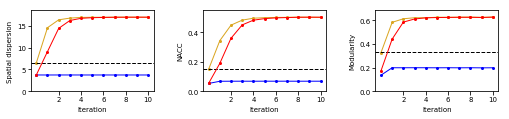

In [42]:
DATA =  pickle.load(open('paper_scripts/iter_data_10T_20R_corruption_figure1_1_7_2019.p','rb'))    
NT=10
ITER=11
keys=list(DATA[0][0][0].keys())
vals=np.zeros((10,NT,ITER,len(keys)))
for z in range(len(DATA)):
    for i in range(DATA[0].shape[0]):  
        for k in range(len(keys)):        
            for j in range(ITER):
                vals[z,i,j,k] = DATA[z][i,j][keys[k]]
vals[:,:,:,0]=vals[:,:,:,0]*10
valsm=vals.mean(0).mean(0)
valss=vals.mean(0).std(0)

data2 = pickle.load(open('paper_scripts/iter_data_50T_figure1_1_7_2019.p','rb'))
keys = list(data2[0,0].keys())  
vals2=np.zeros((50,ITER,len(keys)))
for i in range(data2.shape[0]):  
    for k in range(len(keys)):        
        for j in range(ITER):
            vals2[i,j,k] = data2[i,j][keys[k]]
vals2[:,:,0]=vals2[:,:,0]*10
valsm2=vals2.mean(0)
valss2=vals2.std(0)

fig,axs = plt.subplots(nrows=1,ncols=3)
fig.subplots_adjust(wspace=0.4,left=0.05,right=0.95)
z=0
fig.set_size_inches((7.218307086614,1.5))
nm = ['Spatial dispersion','NACC','Modularity']

valsm2 = np.vstack([di.mean(0),na.mean(0),mo.mean(0)]).T
valss2 = np.vstack([di.std(0),na.std(0),mo.std(0)]).T
valsm3 = np.vstack((dii,nai,moi)).T
for i in range(3):    
    axs[i].errorbar(np.arange(ITER),valsm[:,z],yerr = valss[:,z],color='b',marker='.',linestyle='-',linewidth=1,markersize=4)#,yerr=valss[:,z]); 
    axs[i].errorbar(np.arange(ITER),valsm2[:,z],yerr = valss2[:,z],color='r',marker='.',linestyle='-',linewidth=1,markersize=4)#,yerr=valss[:,z]); 
    axs[i].plot(np.arange(ITER),valsm3[:,z],color='goldenrod',marker='.',linestyle='-',linewidth=1,markersize=4)#,yerr=valss[:,z]); 
    #axs[i,j].fill_between(np.arange(ITER), valsm[:,z]-valss[:,z], valsm[:,z]+valss[:,z],alpha=0.2,color='k')
    #axs[i].spines['right'].set_visible(False)
    axs[i].set_ylim([0,valsm2[:,z].max()*1.1])
    axs[i].tick_params(pad=1)
    #axs[i,j].spines['top'].set_visible(False)  
    #axs[i].spines['bottom'].set_visible(False)
    axs[i].set_xticks([2,4,6,8,10])
    axs[i].set_xticklabels([2,4,6,8,10])
    
    axs[i].set_ylabel(nm[i],fontsize=7,fontname='Arial')
    axs[i].set_xlabel('Iteration',fontsize=7,fontname='Arial')
    f=axs[i].get_xticklabels()
    for j in f: j.set_fontname('Arial'); j.set_fontsize(7)
    f=axs[i].get_yticklabels()
    for j in f: j.set_fontname('Arial'); j.set_fontsize(7)
    
    
    #axs[i].set_title(keys[z])
    z+=1
axs[0].axhline(disp_seur,color='k',linestyle='--',linewidth=1)
axs[1].axhline(nacc_seur,color='k',linestyle='--',linewidth=1)
axs[2].axhline(mod_seur,color='k',linestyle='--',linewidth=1)
plt.savefig('/media/storage/dbox/Dropbox/paper_scripts/METRICS_FIXED.pdf',transparent=True)